In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm#_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from scipy.optimize import minimize
import plotly.express as px
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision 

path = '../Desktop/pku/'
os.listdir(path)

['car_models_json',
 'test_images',
 'train_images',
 'train.csv',
 'train_masks',
 'car_models',
 'camera',
 'sample_submission.csv',
 'test_masks']

In [3]:
## Camera coordinates
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

In [4]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'sample_submission.csv')
train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

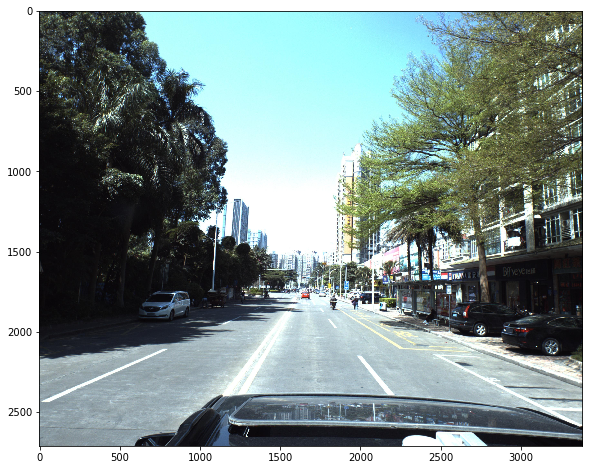

In [5]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(path + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);

In [6]:
## Function to extract position values
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [ ]:
'''
        Other way to do it

image_id_expanded = [item for item, count in 
                     zip(df_train['ImageId'], df_train['NumCars']) for i in range(count)]
prediction_strings_expanded = df_train['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
df_train_expanded = pd.DataFrame(
    {
        'ImageId': image_id_expanded,
        'model_type': prediction_strings_expanded[:,0].astype(int),
        'yaw':prediction_strings_expanded[:,1],
        'pitch':prediction_strings_expanded[:,2],
        'roll':prediction_strings_expanded[:,3],
        'x':prediction_strings_expanded[:,4],
        'y':prediction_strings_expanded[:,5],
        'z':prediction_strings_expanded[:,6]
    })
'''

In [ ]:
inp = train['PredictionString'][46]
print('Example input:', inp)
print()
print('Output:', str2coords(inp))

In [ ]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

plt.figure(figsize=(15,6))
sns.countplot(lens);
plt.xlabel('Number of cars');

# 2D Visualization

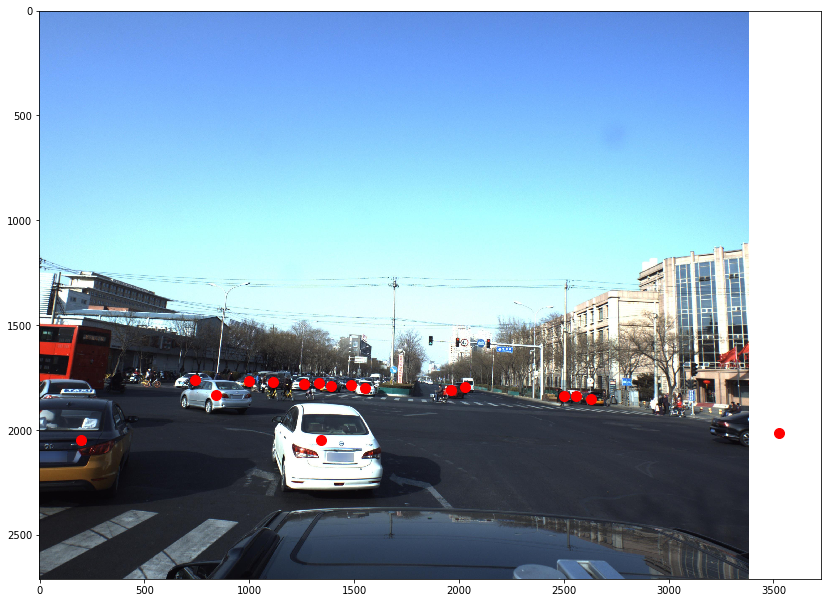

In [7]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

plt.figure(figsize=(14,14))
plt.imshow(imread(path + 'train_images/' + train['ImageId'][2217] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

In [ ]:
xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(18,18))
plt.imshow(imread(path + 'train_images/' + train['ImageId'][2217] + '.jpg'), alpha=0.3)
plt.scatter(xs, ys, color='red', s=10, alpha=0.2);

In [8]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [9]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [10]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [ ]:
n_rows = 7

for idx in range(n_rows):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    img = imread(path + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
    axes[0].imshow(img)
    
    img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
    axes[1].imshow(img_vis)
    plt.show()

## Preprocs

In [11]:
IMG_WIDTH = 1024
IMG_HEIGHT = IMG_WIDTH // 16 * 5
MODEL_SCALE = 8

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        for k in ['x', 'pitch', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img, flip=False):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 6]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    if flip:
        img = img[:,::-1]
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels, flip=False):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 6) * IMG_WIDTH / (img.shape[1] * 4/3) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict, flip)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    if flip:
        mask = np.array(mask[:,::-1])
        regr = np.array(regr[:,::-1])
    return mask, regr

In [13]:
points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr

print('len(points_df)', len(points_df))
points_df.head()

len(points_df) 49684


x         y        z       yaw    pitch     roll
0   7.96539   3.20066  11.0225  0.254839 -2.57534 -3.10256
1   9.60332   4.66632  19.3390  0.181647 -1.46947 -3.12159
2  10.39000  11.22190  59.7825  0.163072 -1.56865 -3.11754
3  -9.59236   5.13662  24.7337  0.141942 -3.13950  3.11969
4   9.83335  13.26890  72.9323  0.163068 -2.08578 -3.11754

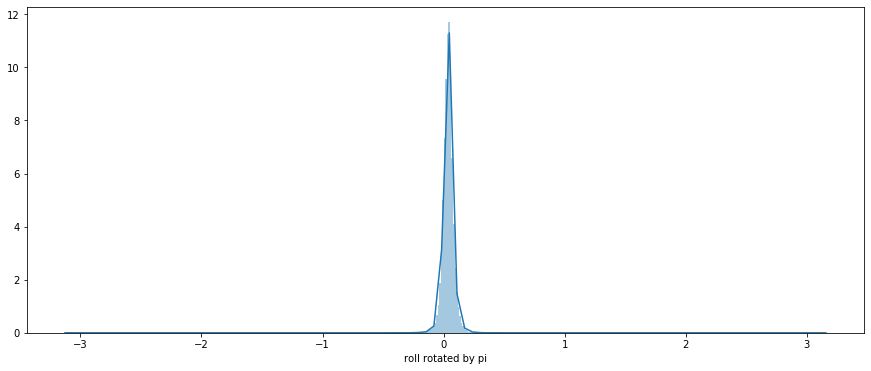

In [14]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

plt.figure(figsize=(15,6))
sns.distplot(points_df['roll'].map(lambda x: rotate(x, np.pi)), bins=500);
plt.xlabel('roll rotated by pi')
plt.show()

img.shape (320, 1024, 3) std: 0.29819912
mask.shape (40, 128) std: 0.031234737
regr.shape (40, 128, 7) std: 0.013211883


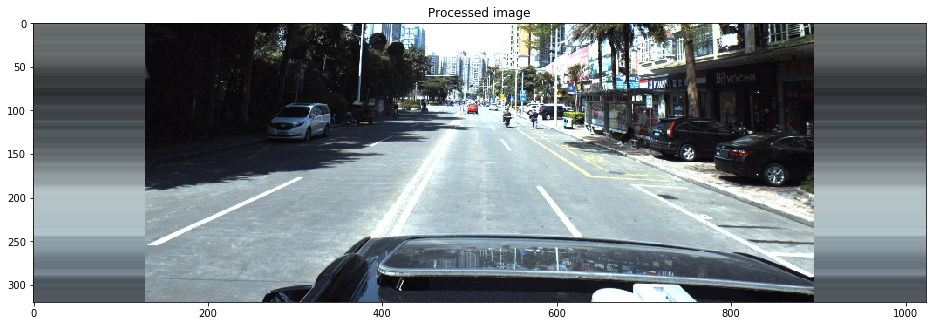

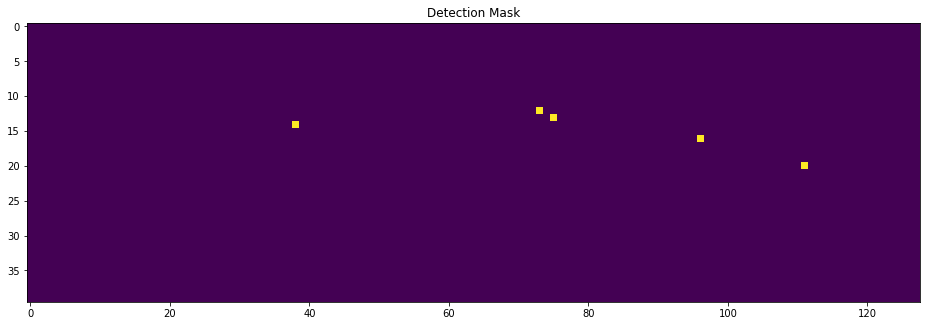

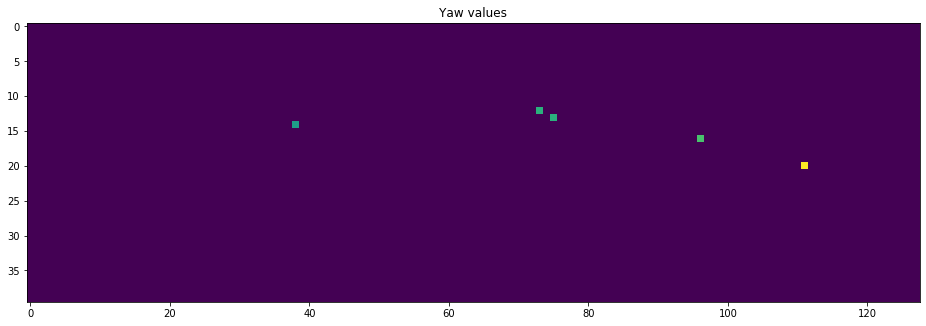

In [15]:
img0 = imread(path + 'train_images/' + train['ImageId'][0] + '.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, train['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(16,16))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

In [16]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0, flipped=False):
    def distance_fn(xyz):
        x, y, z = xyz
        xx = -x if flipped else x
        slope_err = (xzy_slope.predict([[xx,z]])[0] - y)**2
        x, y = convert_3d_to_2d(x, y, z)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        y = (y + IMG_SHAPE[1] // 6) * IMG_WIDTH / (IMG_SHAPE[1] * 4 / 3) / MODEL_SCALE
        return max(0.2, (x-r)**2 + (y-c)**2) + max(0.4, slope_err)
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z_new

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, flipped=False):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > 0)
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = \
                optimize_xy(r, c,
                            coords[-1]['x'],
                            coords[-1]['y'],
                            coords[-1]['z'], flipped)
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [17]:
zy_slope = LinearRegression()
X = points_df[['z']]
y = points_df['y']
zy_slope.fit(X, y)
print('MAE without x:', mean_absolute_error(y, zy_slope.predict(X)))

# Will use this model later
xzy_slope = LinearRegression()
X = points_df[['x', 'z']]
y = points_df['y']
xzy_slope.fit(X, y)
print('MAE with x:', mean_absolute_error(y, xzy_slope.predict(X)))

print('\ndy/dx = {:.3f}\ndy/dz = {:.3f}'.format(*xzy_slope.coef_))

MAE without x: 0.6553782352986744
MAE with x: 0.4481661289004144

dy/dx = 0.051
dy/dz = 0.169


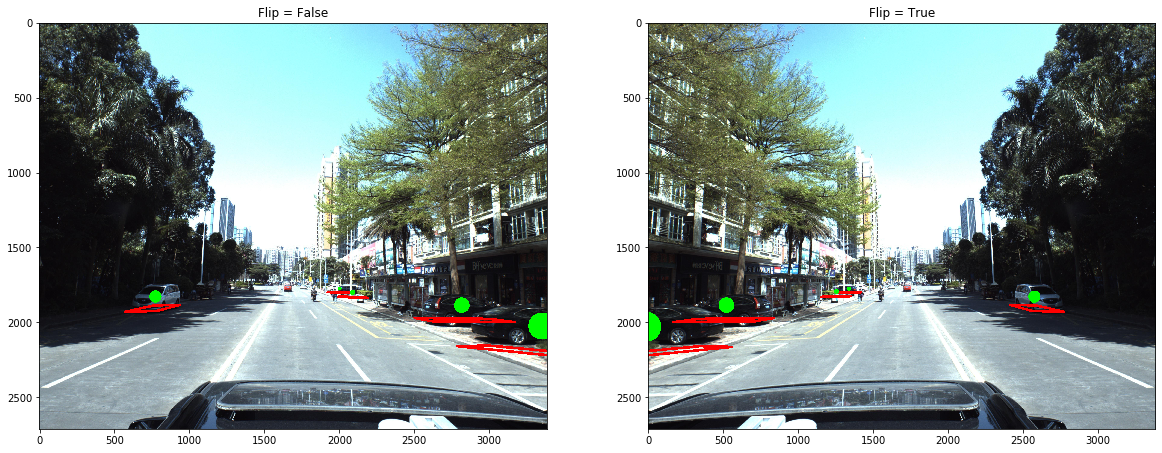

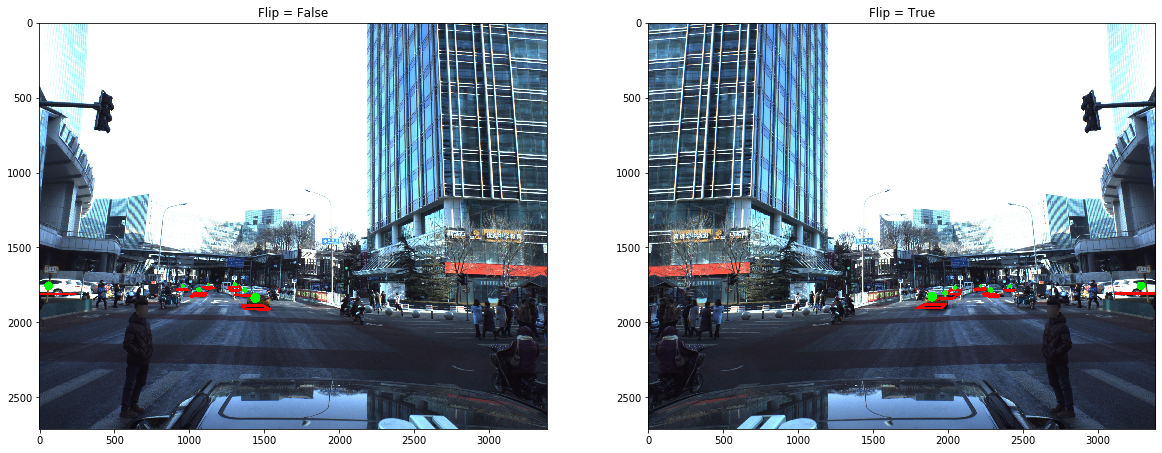

In [18]:
for idx in range(2):
    fig, axes = plt.subplots(1, 2, figsize=(20,20))
    
    for ax_i in range(2):
        img0 = imread(path + 'train_images/' + train['ImageId'].iloc[idx] + '.jpg')
        if ax_i == 1:
            img0 = img0[:,::-1]
        img = preprocess_image(img0, ax_i==1)
        mask, regr = get_mask_and_regr(img0, train['PredictionString'][idx], ax_i==1)
        regr = np.rollaxis(regr, 2, 0)
        coords = extract_coords(np.concatenate([mask[None], regr], 0), ax_i==1)
        
        axes[ax_i].set_title('Flip = {}'.format(ax_i==1))
        axes[ax_i].imshow(visualize(img0, coords))
    plt.show()

In [19]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Augmentation
        flip = False
        if self.training:
            flip = np.random.randint(10) == 1
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0, flip=flip)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        mask, regr = get_mask_and_regr(img0, labels, flip=flip)
        regr = np.rollaxis(regr, 2, 0)
        
        return [img, mask, regr]

In [20]:
train_images_dir = path + 'train_images/{}.jpg'
test_images_dir = path + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, training=True)
dev_dataset = CarDataset(df_dev, train_images_dir, training=False)
test_dataset = CarDataset(df_test, test_images_dir, training=False)

In [21]:
BATCH_SIZE = 4

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
!pip3 install efficientnet-pytorch

In [22]:
from efficientnet_pytorch import EfficientNet

In [23]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [24]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [25]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 10

model = MyUNet(8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth" to /home/rubn/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:21<00:00, 1.01MB/s]


Loaded pretrained weights for efficientnet-b0


In [26]:
def criterion(prediction, mask, regr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    
    # Sum
    loss = mask_loss + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [27]:
def train_model(epoch, history=None):
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))

def evaluate_model(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    print('Dev loss: {:.4f}'.format(loss))

In [28]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)

100%|██████████| 1055/1055 [16:19<00:00,  1.08it/s]


Train Epoch: 0 	LR: 0.001000	Loss: 44.771057


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 33.5444


100%|██████████| 1055/1055 [16:22<00:00,  1.07it/s]


Train Epoch: 1 	LR: 0.001000	Loss: 30.091534


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 28.7062


100%|██████████| 1055/1055 [16:20<00:00,  1.08it/s]


Train Epoch: 2 	LR: 0.001000	Loss: 20.102310


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 26.1905


100%|██████████| 1055/1055 [16:22<00:00,  1.07it/s]


Train Epoch: 3 	LR: 0.000100	Loss: 16.975977


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 24.0038


100%|██████████| 1055/1055 [16:21<00:00,  1.07it/s]


Train Epoch: 4 	LR: 0.000100	Loss: 25.251270


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 24.1969


100%|██████████| 1055/1055 [16:21<00:00,  1.07it/s]


Train Epoch: 5 	LR: 0.000100	Loss: 25.363768


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 23.7900


100%|██████████| 1055/1055 [16:22<00:00,  1.07it/s]


Train Epoch: 6 	LR: 0.000010	Loss: 13.697908


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 24.5876


100%|██████████| 1055/1055 [16:22<00:00,  1.07it/s]


Train Epoch: 7 	LR: 0.000010	Loss: 24.218744


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 25.0332


100%|██████████| 1055/1055 [16:23<00:00,  1.07it/s]


Train Epoch: 8 	LR: 0.000010	Loss: 9.182612


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 25.1353


100%|██████████| 1055/1055 [16:22<00:00,  1.07it/s]


Train Epoch: 9 	LR: 0.000001	Loss: 18.614964
Dev loss: 25.4200
CPU times: user 2h 37min 37s, sys: 48min 21s, total: 3h 25min 59s
Wall time: 2h 45min 11s


In [29]:
torch.save(model.state_dict(), './model.pth')

In [30]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

100%|██████████| 506/506 [05:08<00:00,  1.64it/s]


In [32]:
test = pd.read_csv(path + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
test.head()

ImageId                                   PredictionString
0  ID_18fb86d04  0.14673884 0.006605751937689944 -3.09997600515...
1  ID_ce06d4dc1  0.12746535 -0.002813404402451723 -3.0874977504...
2  ID_afe07078f  0.13213089 3.1393443424046383 -3.1068943982296...
3  ID_37caf75aa  0.1428878 0.02159060363822828 -3.0862656628065...
4  ID_7655363ca  0.15294695 3.133800797541179 -3.11018638511235...